# ForSE: 
## Foreground Scale Extender

In [1]:
from forse.networks.dcgan import *
import matplotlib.pyplot as plt
from forse.tools.nn_tools import *
from forse.tools.img_tools import *
from forse.tools.mix_tools import *

Using TensorFlow backend.


In [2]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/', img_size=(64, 64))

In [3]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/pswap_10/'
dcgan.discriminator = load_model(dir_models+'discrim_99999.h5')
dcgan.generator = load_model(dir_models+'generat_99999.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/common/software/tensorflow/intel-tensorflow/1.13.1-py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
accs = np.load(dir_models+'acc_dreal_dfake_99999.npy')

Text(0, 0.5, 'Discriminator accuracy')

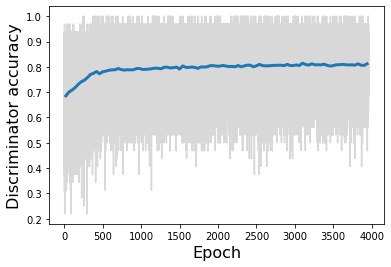

In [5]:
data = (accs[:,1]+accs[:,0])/2.
x_binned, data_binned = bin_array(data, bins=1000)
plt.plot(np.arange(len(data))/25., data, color='grey', alpha=0.3)
plt.plot(x_binned/25, data_binned, lw=3)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Discriminator accuracy', fontsize=16)

In [6]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_set2.npy'
X_train, X_test, Y_train, Y_test = load_training_set(training_path+training_file)
gen_imgs_test = dcgan.generator.predict(X_test)
gen_imgs_train = dcgan.generator.predict(X_train)

Text(0.5, 1.0, 'HFI 5°')

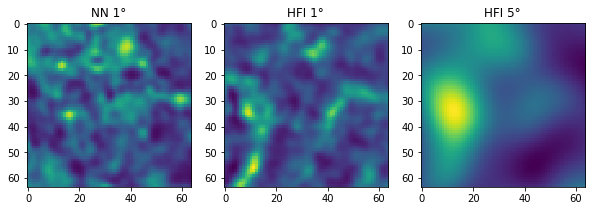

In [7]:
N = 53
vminm = np.min(X_train[N, :, :, 0])
vmaxm = np.max(X_train[N, :, :, 0])
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(gen_imgs_train[N, :, :, 0], vmin=vminm, vmax=vmaxm)
plt.title('NN 1°')
plt.subplot(132)
plt.imshow(Y_train[N, :, :, 0], vmin=vminm, vmax=vmaxm)
plt.title('HFI 1°')
plt.subplot(133)
plt.imshow(X_train[N, :, :, 0], vmin=vminm, vmax=vmaxm)
plt.title('HFI 5°')

In [8]:
patch_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
Ys, Xs = np.load(patch_path+'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_set2.npy')
Yl, Xl = np.load(patch_path+'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix320_set2.npy')
Yl_zoom = np.zeros((1000, 64, 64))
X_edges = []
for i in range(40):
    j = i
    Yl_zoom[i*25:(i+1)*25] = divide_image(Yl[j], 64, 64)[0]
X = Yl_zoom
for i in range(X.shape[0]):
    X[i], Xmin, Xmax = rescale_min_max(X[i], return_min_max=True)
    X_edges.append([Xmin, Xmax])
x_test, x_test2 = split_training_set(X)
X_edges = np.array(X_edges)    

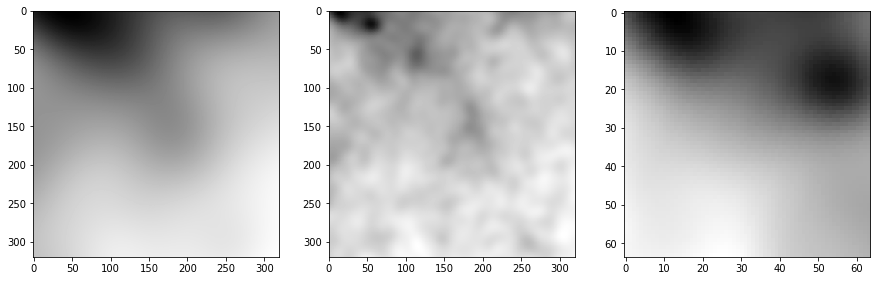

In [24]:
num = 10
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(Xl[num], cmap='binary')
plt.subplot(132)
plt.imshow(Yl[num], cmap='binary')
plt.subplot(133)
plt.imshow(Yl[num][0:64, 0:64], cmap='binary')

In [67]:
gen_imgs_test = dcgan.generator.predict(x_test)

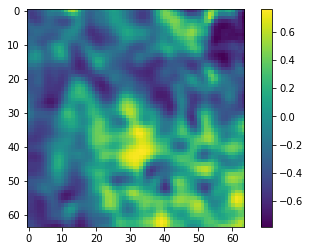

In [68]:
plt.imshow(gen_imgs_test[0, :, :, 0])
plt.colorbar()

In [71]:
pysm_ss, pysm_1d = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR12amin_LR1deg_Npix320_set2.npy')
hfi_ss, hfi_1d = np.load(patch_path+'training_set_1000patches_20x20deg_T_HR12amin_LR1deg_Npix320_set2.npy')

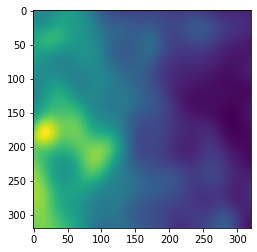

In [81]:
plt.imshow(hfi_1d[1])

In [82]:
pysm_ss_zoom = np.zeros((1000, 64, 64))
pysm_1d_zoom = np.zeros((1000, 64, 64))
hfi_ss_zoom = np.zeros((1000, 64, 64))
hfi_1d_zoom = np.zeros((1000, 64, 64))
pysm_ss_edges = []
for i in range(40):
    j = i
    pysm_ss_zoom[i*25:(i+1)*25] = divide_image(pysm_ss[j], 64, 64)[0]
    pysm_1d_zoom[i*25:(i+1)*25] = divide_image(pysm_1d[j], 64, 64)[0]
    hfi_ss_zoom[i*25:(i+1)*25] = divide_image(hfi_ss[j], 64, 64)[0]
    hfi_1d_zoom[i*25:(i+1)*25] = divide_image(hfi_1d[j], 64, 64)[0]
for i in range(1000):
    ratio = pysm_ss_zoom/pysm_1d_zoom
    pysm_ss_edges.append([ratio[i].min(), ratio[i].max()])
pysm_ss_edges = np.array(pysm_ss_edges)

In [83]:
bnormed_gen = np.copy(gen_imgs_test)
for i in range(800):
    bnormed_gen[i] = (rescale_min_max_back(gen_imgs_test[i], [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))

In [100]:
a = 750
b = a+25
NN_small_scale = unify_images(bnormed_gen[a:b])
large_scale = hfi_1d[int(a/25)]
small_scale = hfi_ss[int(a/25)]

Text(0.5, 1.0, 'PySM Large scales (1 deg)')

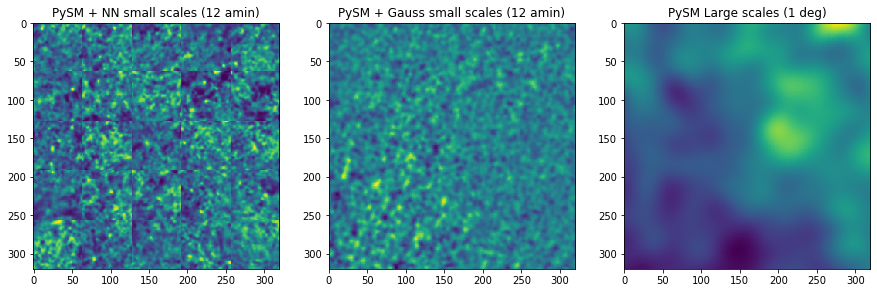

In [101]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow(NN_small_scale)
plt.title('PySM + NN small scales (12 amin)')
plt.subplot(132)
plt.imshow(small_scale/large_scale)
plt.title('PySM + Gauss small scales (12 amin)')
plt.subplot(133)
plt.imshow(large_scale)
plt.title('PySM Large scales (1 deg)')

In [60]:
images_oversamp = divide_image(large_scale, 32, 64)
Xos = np.array(images_oversamp[0])
indx = images_oversamp[2]
weights = images_oversamp[1]

In [61]:
for i in range(Xos.shape[0]):
    Xos[i] = rescale_min_max(Xos[i])
Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
gen_imgs_os = dcgan.generator.predict(Xos)

In [62]:
nn_images_oversamp = np.copy(images_oversamp)
nn_images_oversamp[0] = gen_imgs_os[:, :, :, 0]
for i in range(len(nn_images_oversamp[0])):
    nn_images_oversamp[0][i] = (rescale_min_max_back(nn_images_oversamp[0][i], [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))

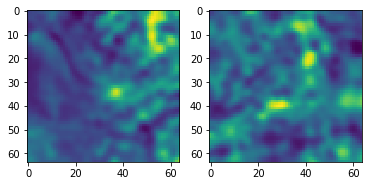

In [63]:
plt.subplot(121)
plt.imshow(nn_images_oversamp[0][0])
plt.subplot(122)
plt.imshow(NN_small_scale[0:64,0:64])

In [24]:
NN_small_scale_apo = apodize_and_unify_images(nn_images_oversamp)

Text(0.5, 1.0, 'PySM Large scales (1 deg)')

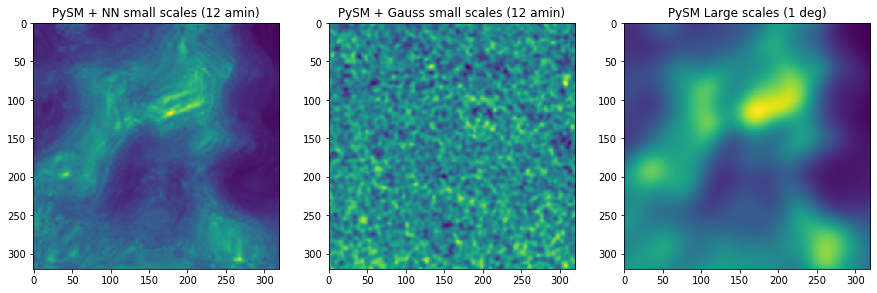

In [25]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow(NN_small_scale_apo*large_scale)
plt.title('PySM + NN small scales (12 amin)')
plt.subplot(132)
plt.imshow(small_scale)
plt.title('PySM + Gauss small scales (12 amin)')
plt.subplot(133)
plt.imshow(large_scale)
plt.title('PySM Large scales (1 deg)')

In [126]:
def calculate_2d_spectrum(Map1,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    #FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap1))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

In [127]:
binned_ell, binned_spectrumLS = calculate_2d_spectrum(large_scale,30,1024,3.75,320)
binned_ell, binned_spectrumSS = calculate_2d_spectrum(small_scale,30,1024,3.75,320)
binned_ell, binned_spectrumNN = calculate_2d_spectrum(NN_small_scale_apo*large_scale,30,1024,3.75,320)

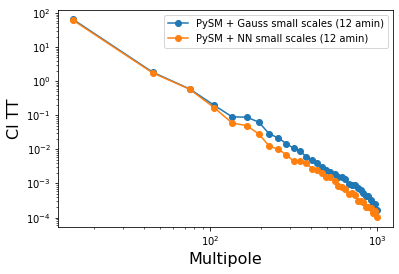

In [129]:
plt.loglog(binned_ell, binned_spectrumSS, '-o', label='PySM + Gauss small scales (12 amin)')
plt.loglog(binned_ell, binned_spectrumNN, '-o', label='PySM + NN small scales (12 amin)')
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('Cl TT', fontsize=16)
plt.legend()